In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ete3
from scipy.optimize import minimize
from tqdm import tqdm


In [219]:
gg_tree_path = "greengenes/data/gg_13_5_otus_99_annotated.tree"
seed_tree_path = "seedplants/tree.nwk"
seed_traits_path = "seedplants/traits.csv"

In [220]:
class PagelsLambda(object):
    def __init__(self, tree, **kwargs):
        """Initialize PagelsLambda object. Takes ete tree or path to tree file."""
        if isinstance(tree, str):
            tree = ete3.Tree(tree, **kwargs)
        self.tree = tree
        self.N = len(tree.get_leaves())

        # Raw covariance matrix has C[i,j] = d(MRCA(i,j), root)
        self.C = np.zeros((self.N, self.N))
        for i, leaf_i in enumerate(self.tree):
            for j, leaf_j in enumerate(self.tree):
                # If i == j, then the distance is leaf to root
                mrca = self.tree.get_common_ancestor(leaf_i, leaf_j)
                self.C[i, j] = mrca.get_distance(self.tree)

        self.z0 = None  # value at root
        self.sigma2 = None  # rate of evolution

    def fit(self, x: np.ndarray, y=None, method="optimize") -> None:
        """
        Fit Pagels lambda to a set of traits.

        Args:
            x: (N, 1) array of trait values
            y: ignored (for sklearn compatibility)
            method: "grid" or "optimize":
                "grid" uses a grid search to find the best lambda
                "optimize" uses scipy.optimize.minimize to find the best lambda

        Returns:
            None (sets self.lam)
        """

        if x.ndim == 1:
            x = x.reshape(x.shape[0], 1)

        # Remove missing values: need to remove from covariance matrix too
        missing = np.isnan(x)[:, 0]
        x = x[~missing, :]
        C = self.C[~missing, :][:, ~missing]

        # Maximum likelihood estimation
        if method == "grid":
            max_ll = -np.inf
            lam_mle = None
            for lam in np.linspace(0, 1, 101):
                C_lam = self.rescale_cov(lam, cov=C)
                z0, sigma2, ll = self.mle(x, C_lam)
                if ll > max_ll:
                    max_ll = ll
                    lam_mle = lam
            self.lam = lam_mle
        elif method == "optimize":

            def neg_ll(lam):
                C_lam = self.rescale_cov(lam, cov=C)
                z0, sigma2, ll = self.mle(x, C_lam)
                return -ll

            res = minimize(neg_ll, x0=0.5, bounds=[(0, 1)])
            self.lam = res.x[0]
        else:
            raise ValueError("Unknown method for fitting Pagels lambda.")

    def rescale_cov(self, lam: float, cov: np.ndarray = None) -> np.ndarray:
        """
        Rescale covariance matrix by lambda.
        
        Args:
            lam: lambda value
            cov: covariance matrix to rescale. If None, use self.C.

        Returns:
            Rescaled covariance matrix.
        """
        if cov is None:
            cov = self.C

        C_lam = cov.copy() * lam
        np.fill_diagonal(C_lam, cov.diagonal())

        return C_lam

    def mle(self, x: np.ndarray, C_lam: np.ndarray) -> (float, float, float):
        """
        Estimate z0 and sigma2 for Brownian motion, plus log-likelihood.
        
        Args:
            x: (M, 1) array of trait values for M <= N
            C_lam: (M, M) rescaled covariance matrix
        
        Returns:
            z0: value at root
            sigma2: rate of evolution
            ll: log-likelihood of the data given the model
        """

        N = len(x)

        C_inv = np.linalg.pinv(C_lam)

        # First, get z0
        one = np.ones(shape=(N, 1))
        # z0_front = np.linalg.pinv(one.T @ C_inv @ one)
        # z0_end = one.T @ C_inv @ x
        # z0 = z0_front * z0_end
        z0 = (np.linalg.pinv(one.T @ C_inv @ one) @ (one.T @ C_inv @ x)).item()

        # Next, get sigma2
        x0 = x - z0 * one  # (N, 1)
        sigma2 = x0.T @ C_inv @ x0 / N  # (1, N) @ (N, N) @ (N, 1) = (1, 1)

        # temp = XSubZ0_vector.T @ pinv(deltaSquare * C)) @ XSubZ0_vector
        ll_num = -0.5 * x0.T @ np.linalg.pinv(sigma2 * C_lam) @ x0
        ll_denom = 0.5 * (
            N * np.log(2 * np.pi) + np.linalg.slogdet(sigma2 * C_lam)[1]
        )
        ll = (ll_num - ll_denom)[0][0]

        return z0, sigma2, ll


pl = PagelsLambda(seed_tree_path, format=0)


In [222]:
x = np.random.multivariate_normal(mean=np.zeros(pl.N), cov=pl.C)
pl.fit(x)
pl.lam

0.9991175719160679

100%|██████████| 21/21 [00:32<00:00,  1.57s/it]


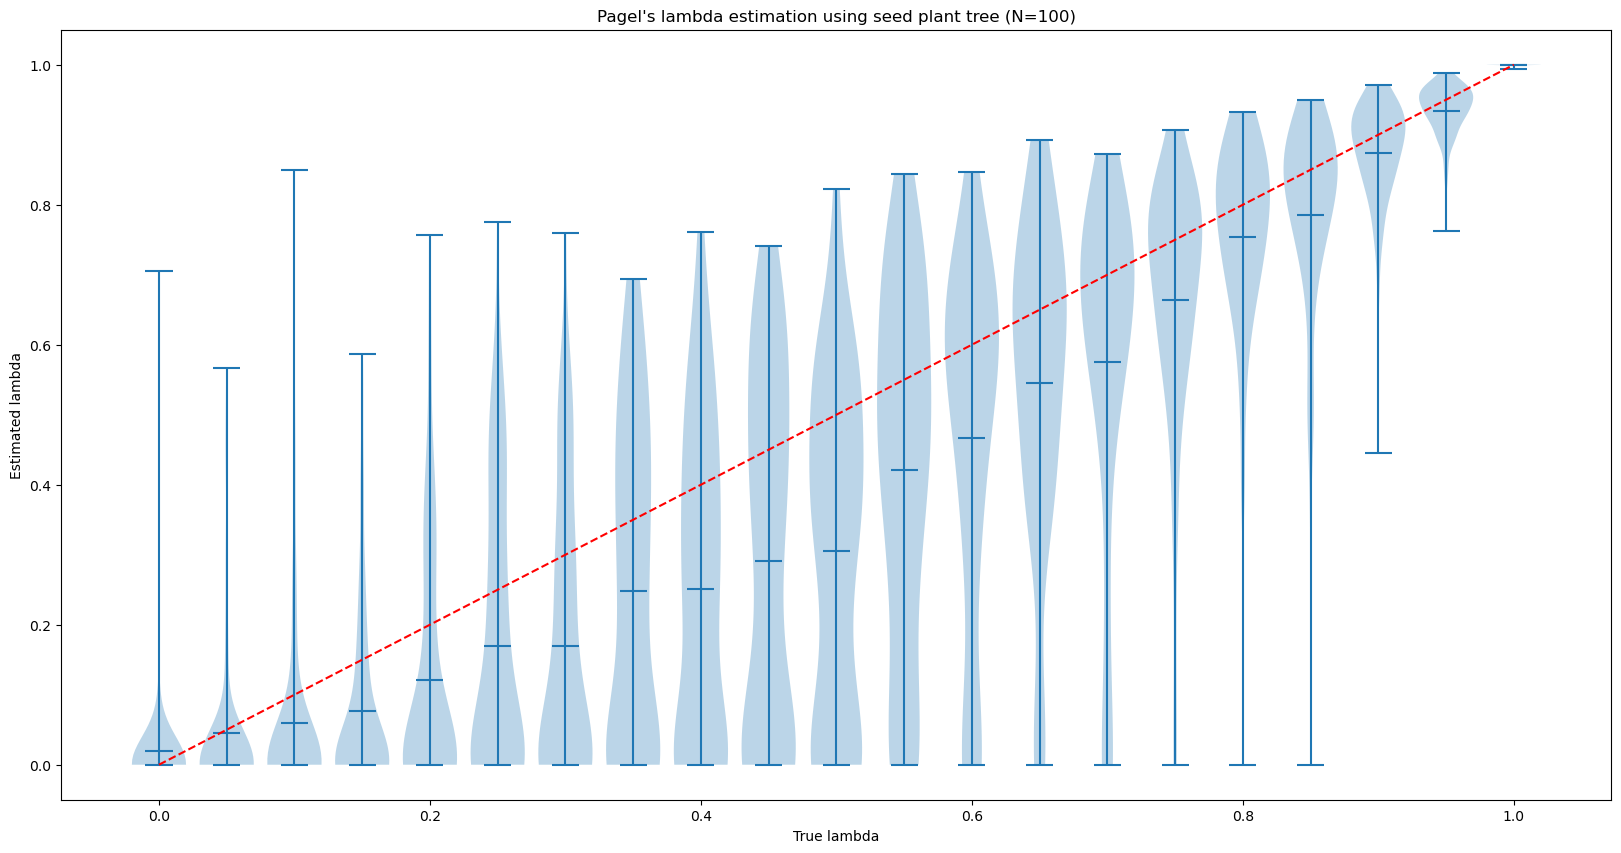

In [232]:
n_reps = 100

estimates = []
lambdas = np.linspace(0, 1, 21)
# Test estimates for a variety of lambdas
for lam in tqdm(lambdas):
    lam_ests = []
    for i in range(n_reps):
        pl.fit(
            np.random.multivariate_normal(np.zeros(pl.N), pl.rescale_cov(lam))
        )
        lam_ests.append(pl.lam)
    estimates.append(lam_ests)

# Boxplots!
fig = plt.figure(figsize=(20, 10))
plt.violinplot(
    dataset=estimates,
    positions=lambdas,
    widths=[0.04] * len(lambdas),
    showmeans=True,
)
plt.plot(lambdas, lambdas, color="red", linestyle="--", label="True lambda")
plt.xlabel("True lambda")
plt.ylabel("Estimated lambda")
plt.title(f"Pagel's lambda estimation using seed plant tree (N={n_reps})")

plt.show()
